# GenIPA - A generative AI approach to IPA-transcription

In [2]:
from importlib import reload
import utils
reload(utils)

<module 'utils' from '/Users/hannes/Documents/Programming/GitHub/GenIpA/utils.py'>

# Transcriptions

One of the biggest challenges for a rule based text to phonetics transcriber lies in handling homographs, words which are written the same, but have different meanings and are pronounced differently, depending on the context. For example: "read" in "I read a book yesterday", and "I like to read books" are not pronounced equally. Looking at the popular ipa transcribers out there, it seems that they are having problem tackling this, among other things. Lets see if our transformer based solution can address the issue efficiently.

Below is an excerpt from https://unalengua.com/ipa-translate?ttsLocale=de-DE&voiceId=Marlene&text=&hl=en&sl=de

It can't handle homographs:

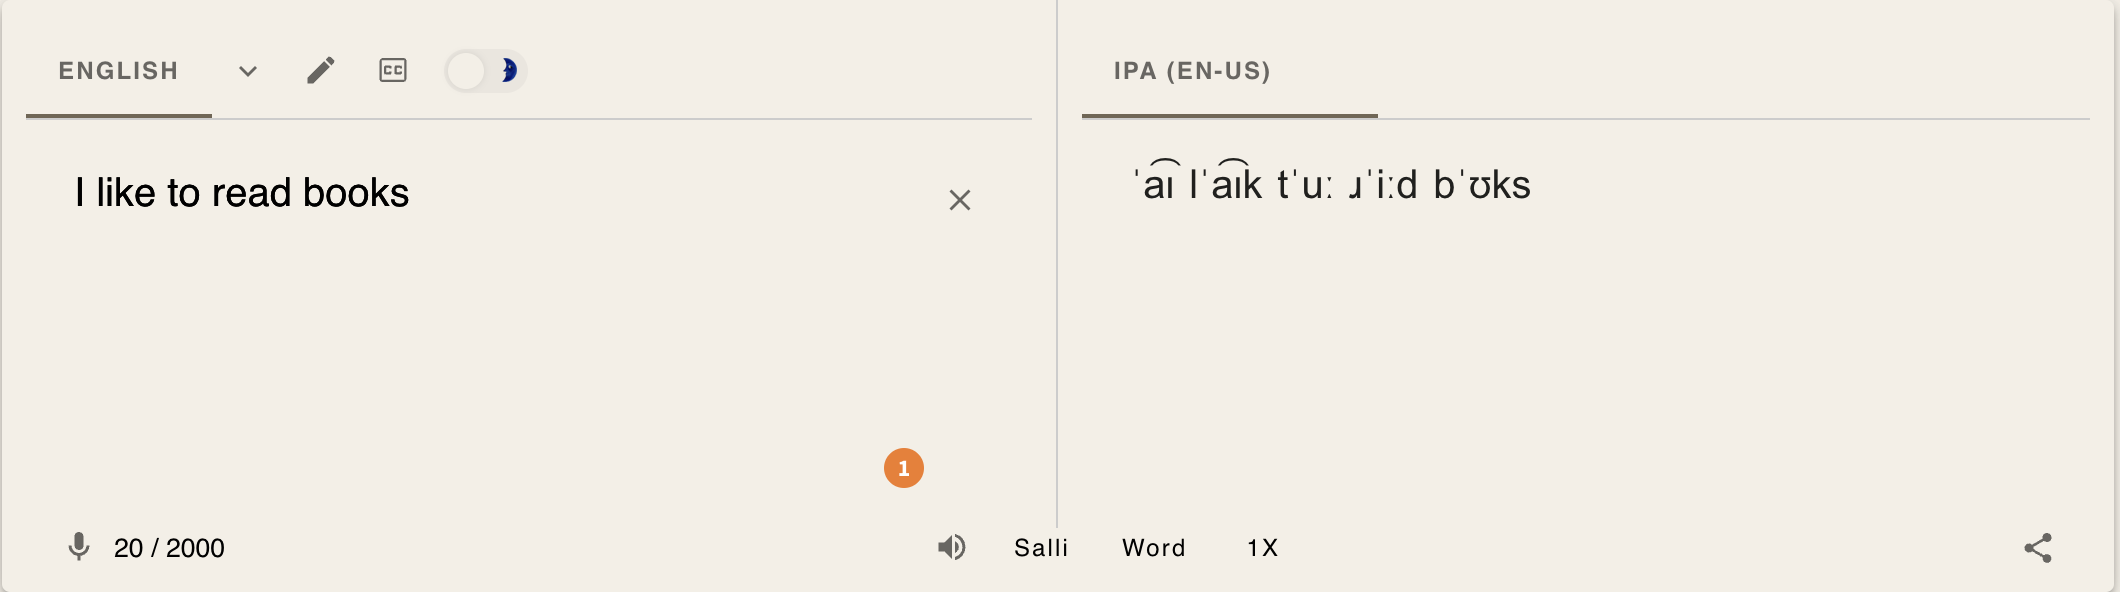

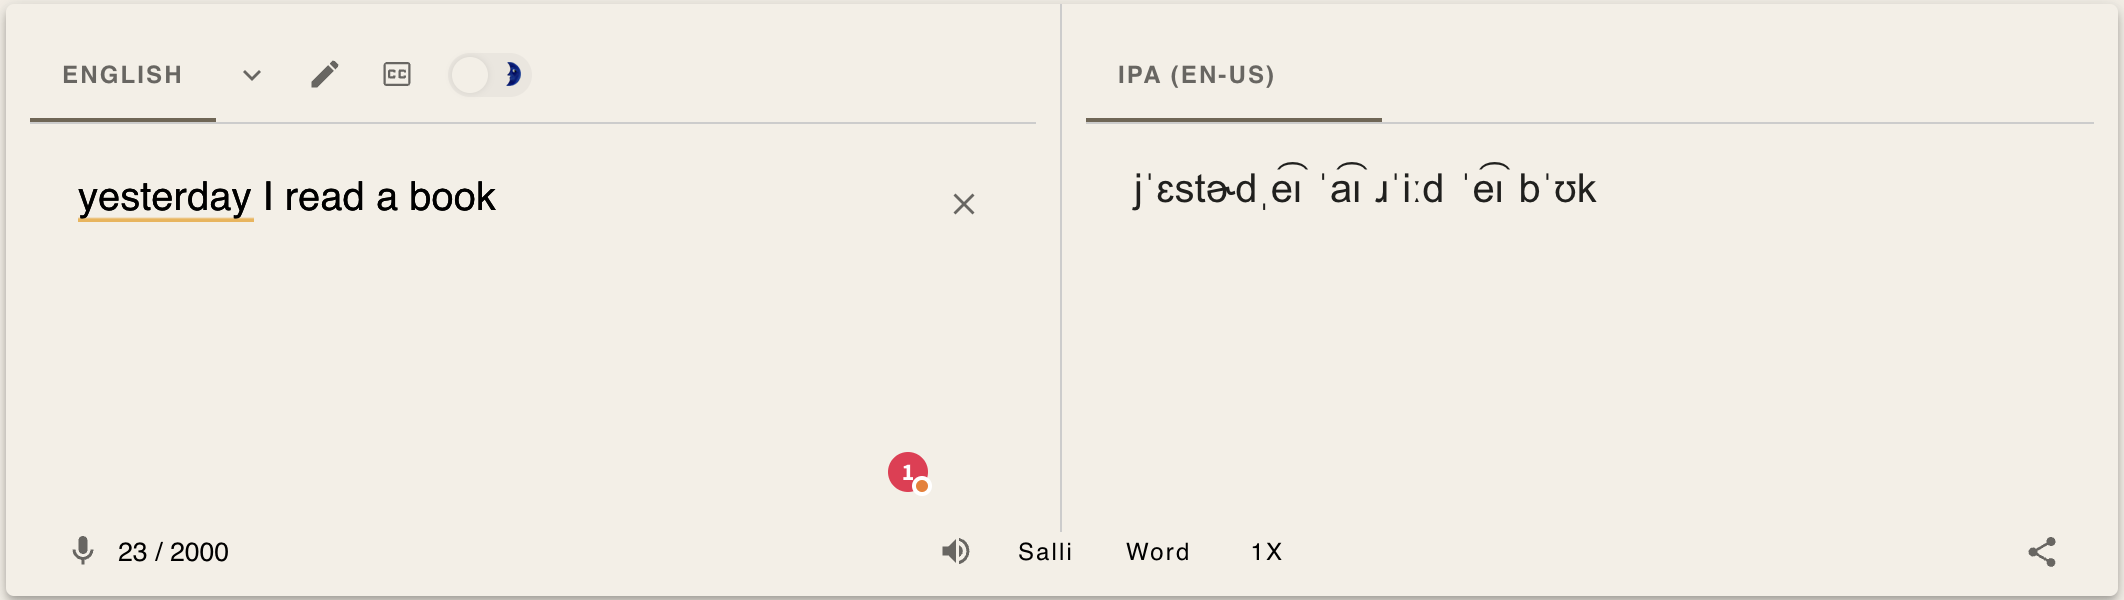

It can't detect spelling errors

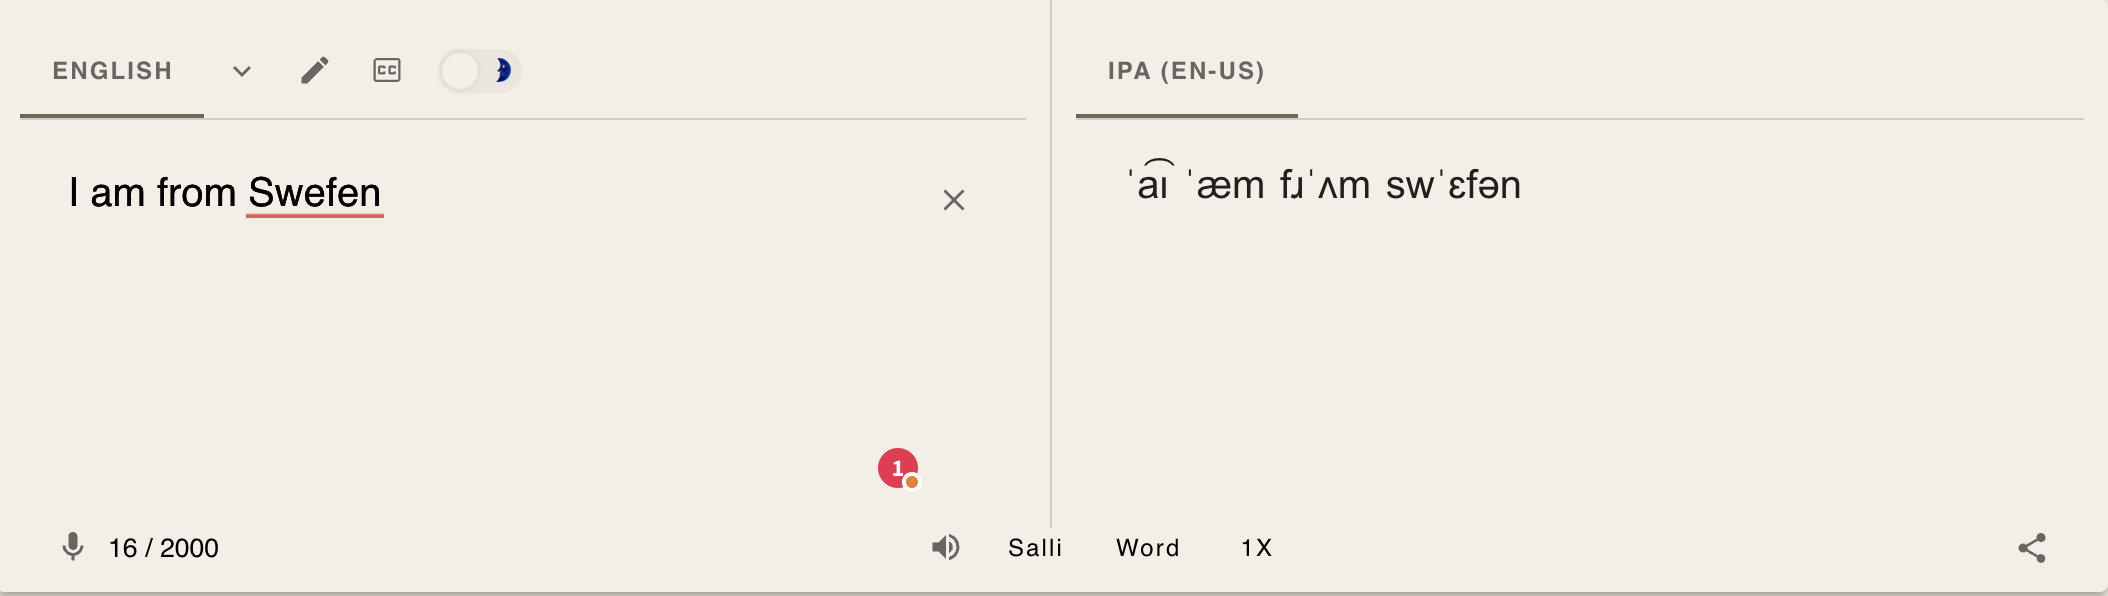

## GPT-3.5-Turbo:

The API from OpenAI is used to get a completion, which is specifed to provide only IPA translations

In [ ]:
# The function used can be found under utils.py
"""
def get_ipa_openai(prompt, model="gpt-3.5-turbo", temperature=0, lang = None):
    if lang != None:
        messages = [
            {"role": "system", "content": "You will be provided with a string of text in " + lang + ". Answer with an IPA transcription of it, using only your own knowledge, nothing else."},
            {"role": "user", "content": prompt},
            ]
    else:
        messages = [
            {"role": "system", "content": "You will be provided with a string of text. Answer with an IPA transcription of it, using only your own knowledge, nothing else."},
            {"role": "user", "content": prompt},
            ]
    response = openai.chat.completions.create(model=model,
                                              messages=messages,
                                              temperature=temperature
                                              )
    return response.choices[0].message.content
"""

Can it handle Homographs?

In [14]:
utils.get_ipa_openai('I like to read books')

'/aɪ laɪk tu rid bʊks/'

In [2]:
utils.get_ipa_openai("I read a book yesterday")

'/aɪ rɛd ə bʊk ˈjɛstərˌdeɪ/'

Spelling errors?

In [15]:
utils.get_ipa_openai("I am from Swefen")

'/aɪ æm frɒm ˈswiːdən/'

Different language variations?

In [16]:
utils.get_ipa_openai("I like to drink water", lang='US-english')

'/aɪ laɪk tu drɪŋk ˈwɔtər/'

In [17]:
utils.get_ipa_openai("I like to drink water", lang='UK-english')

'/aɪ laɪk tə drɪŋk ˈwɔːtə/'

It is a success!

Lets try to enhance it, using a RAG with a swedish phonetic dictionary from the open source project ipa-dict "(https://github.com/open-dict-data/ipa-dict)", where such differences between words are marked

Lets see if it can also handle other languages and more difficult tasks.
In swedish, there exists homographs based on intonation: 
- "Anden" the definite form of Duck - the Duck.
- "Anden", the definite form of Genie - the Genie;
#
they are different in the sense that the first one has one "peak" - accent 1, and the other one has two peaks - accent 2.
This is completly decided from context and in phonetical writing it is marked with a "2" if the word is accent 2

In [8]:
from llama_index.core import VectorStoreIndex
from utils import create_retrieve_index
DOCS_DIR = "data_rag/"
PERSIST_DIR = "index/"
VECTORINDEXDIR = PERSIST_DIR + 'VectorStoreIndex'
vectorstoreindex = utils.create_retrieve_index(VECTORINDEXDIR, DOCS_DIR, VectorStoreIndex, 'sv.txt')
query_engine = utils.get_query_engine(vectorstoreindex)

Reading from Index...
Done!


In [15]:
utils.get_ipa_openai("Anden bor i flaskan") # The genie lives in the lamp

'/ˈanːdɛn buːr i ˈflasːkan/'

In [14]:
utils.get_ipa_openai("Anden simmar i vattnet") # the duck is swimming in the water

'/ˈanːdɛn ˈsɪmːar i ˈvatːnɛt/'

In [13]:
print(utils.get_ipa_rag(query_engine=query_engine, text = "Anden simmar i vattnet"))

/²anːdɛn s'ɪmːar i v'atːnɛt/


In [12]:
print(utils.get_ipa_rag(query_engine=query_engine, text = "Anden bor i flaskan"))

/²'andɛn buːr i fl'askan/


It marks correctly that there is a version of the word which uses another intonation, but it can't differentiate between them. Instead what would be needed is a large amount of labeled data with complete sentences in written language and high quality ipa transcriptions. This type of data is unfortunately very scarce and difficult to create. As such, what can be achieved right now is an improvement to the existing rulebased transcribers, and further improvement would be the creation of training data to allow either the finetuning of an open-source model or further improvement of the RAG. 